# Analyzing all 6 species worth of gene level data.





## Necessary Imports

In [27]:
%matplotlib notebook
import pandas as pd, numpy as np, random
import matplotlib.pyplot as plt, matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from sklearn.cluster import KMeans
import seaborn as sns
import similaritymeasures as sm
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

## Constants

In [28]:
num_clusters = 8

Dark2 = cm.get_cmap('Dark2', num_clusters)
tab10 = cm.get_cmap('tab10', num_clusters)

all_species = [
    "DC10",
    "DC30",
    "DC40",
    "DC50",
    "DC60",
    "DC70"
]

cluster_colors = [
    'mediumvioletred',
    'skyblue', 
    'khaki',
    'lightpink', 
    'tomato',
    'mediumseagreen',
    'darkslateblue',
    'teal'
]

# These are the CSV file paths for each species:
csvs = [
    'data/gene_level/DC10_GL_clust-smry.csv',
    'data/gene_level/DC30_GL_clust-smry.csv',
    'data/gene_level/DC40_GL_clust-smry.csv',
    'data/gene_level/DC50_GL_clust-smry.csv',
    'data/gene_level/DC60_GL_clust-smry.csv',
    'data/gene_level/DC70_GL_clust-smry.csv'
]

## Reading Data

In [29]:
# We only need a subset of the columns from each CSV:
columns = [
    'PanID',
    'sum_meanTPM_Ti',
    'sum_meanTPM_Tii',
    'sum_meanTPM_Tiii',
    'sum_meanTPM_Tiv', 
    'TC_qval',
    'Pannot'
]

# We add all the csv's to a dataframe.
data = pd.DataFrame()

# Temp list to hold dataframes prior to concatination.
dfs = []

for csv in csvs:
    
    # Read CSV into dataframe. Only read some of the columns.
    df = pd.read_csv(csv, usecols=columns)
    
    # Remove rows that have missing values and/or infinite values. 
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['sum_meanTPM_Ti', 'sum_meanTPM_Tii', 'sum_meanTPM_Tiii', 'sum_meanTPM_Tiv','TC_qval'])
    
    # Infer the data type of each column and cast as needed.
    df = df.infer_objects()
    
    # Append the data frame to the list of data frames.
    dfs.append(df)
    
# Each CSV eas read into its own dataframe. Here we concat them into one.
data = pd.concat(dfs, keys=all_species, names=['species', 'index'])

data = data.reset_index()

data = data.drop(columns=['index'])

# Show the first few rows of data.
data.head()

species          PanID  sum_meanTPM_Ti  sum_meanTPM_Tii  sum_meanTPM_Tiii  \
0    DC10      PTHR10012       13.196876         7.264274         10.564025   
1    DC10      PTHR10013       53.034548        49.108467         69.035903   
2    DC10  PTHR10013:SF0       34.639727        32.254397         56.410873   
3    DC10      PTHR10019        9.335783        12.274420         10.058933   
4    DC10      PTHR10025      223.510098       199.098955        127.037891   

   sum_meanTPM_Tiv       TC_qval  \
0        18.017042  2.056584e-03   
1        84.880485  2.002715e-02   
2        62.219843  5.108352e-05   
3        12.618621  5.295532e-03   
4       208.300745  9.105388e-08   

                                              Pannot  
0  SERINE/THREONINE-PROTEIN PHOSPHATASE 2A REGULA...  
1            GENERAL VESICULAR TRANSPORT FACTOR P115  
2            GENERAL VESICULAR TRANSPORT FACTOR P115  
3                                               SNF5  
4  TETRAHYDROFOLATE DEHYDROGENASE/CYCLOHYDROLASE ...

## Q Value Filtering

We only care about the genes that have low Timecourse Corrected P-Values (TC_qval).
So we remove all genes from each species that have TC_qval's greater than 0.1.

In [30]:
# Remove genes with high TC_qval's.
data = data[data['TC_qval'] < 0.1]

# We are done with the TC_qval column, so we can remove it. 
data = data.drop(columns=['TC_qval'])

# Show the first few rows of data.
data.head()

species          PanID  sum_meanTPM_Ti  sum_meanTPM_Tii  sum_meanTPM_Tiii  \
0    DC10      PTHR10012       13.196876         7.264274         10.564025   
1    DC10      PTHR10013       53.034548        49.108467         69.035903   
2    DC10  PTHR10013:SF0       34.639727        32.254397         56.410873   
3    DC10      PTHR10019        9.335783        12.274420         10.058933   
4    DC10      PTHR10025      223.510098       199.098955        127.037891   

   sum_meanTPM_Tiv                                             Pannot  
0        18.017042  SERINE/THREONINE-PROTEIN PHOSPHATASE 2A REGULA...  
1        84.880485            GENERAL VESICULAR TRANSPORT FACTOR P115  
2        62.219843            GENERAL VESICULAR TRANSPORT FACTOR P115  
3        12.618621                                               SNF5  
4       208.300745  TETRAHYDROFOLATE DEHYDROGENASE/CYCLOHYDROLASE ...

## Exploratory Plot

Each gene has expression levels given at 4 different time points. For each species we take each one of those time points and plot them. Since we can only plot in 3 dimensions, the last time point is represented as color.

<IPython.core.display.Javascript object>


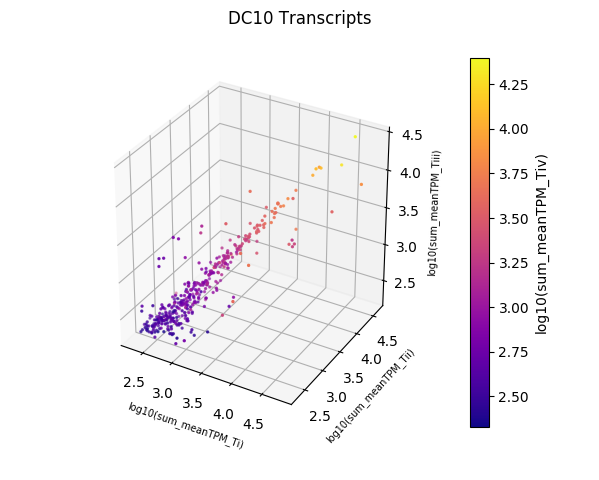

<IPython.core.display.Javascript object>


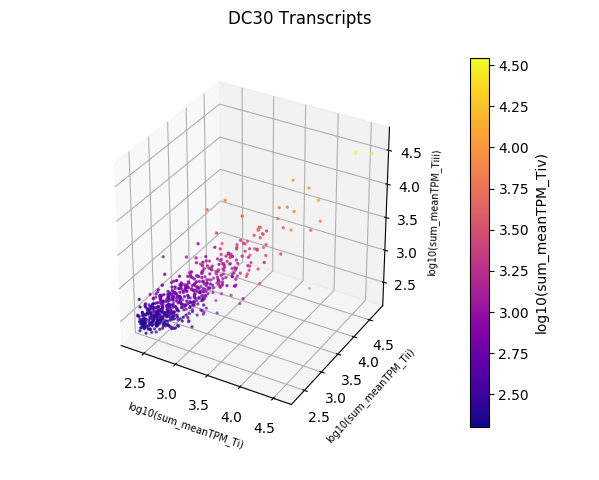

<IPython.core.display.Javascript object>


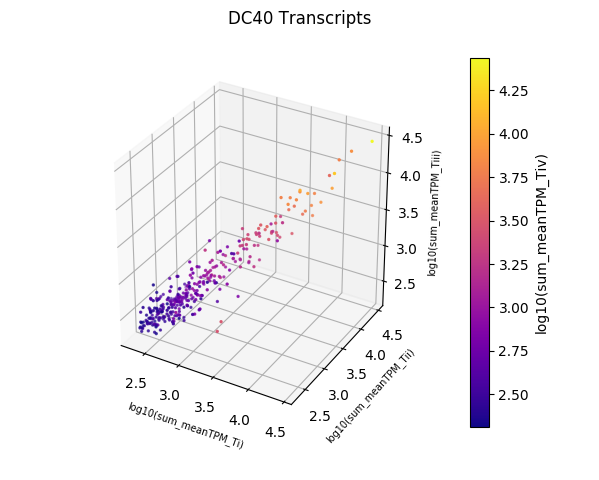

<IPython.core.display.Javascript object>


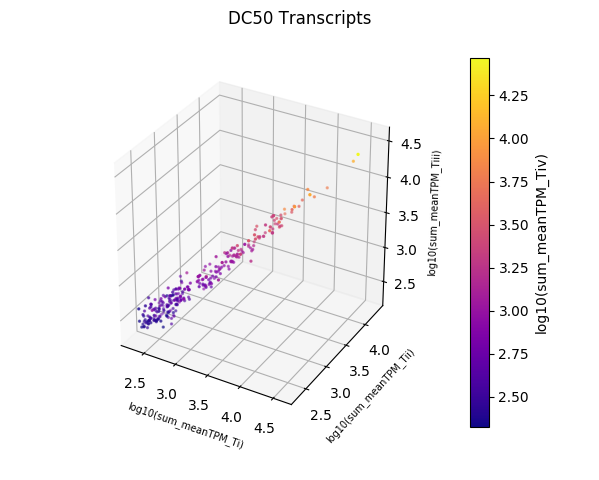

<IPython.core.display.Javascript object>


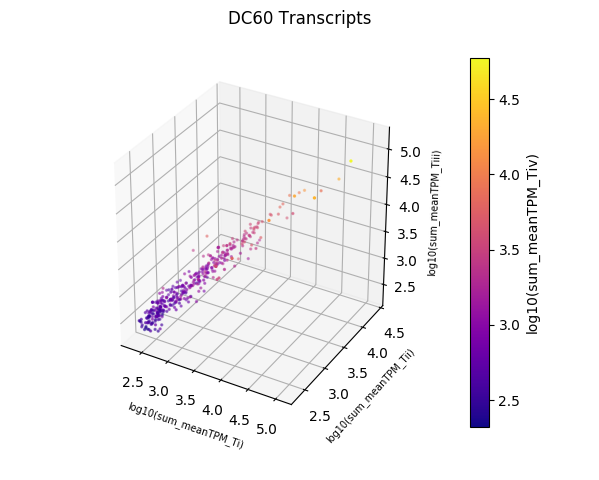

<IPython.core.display.Javascript object>


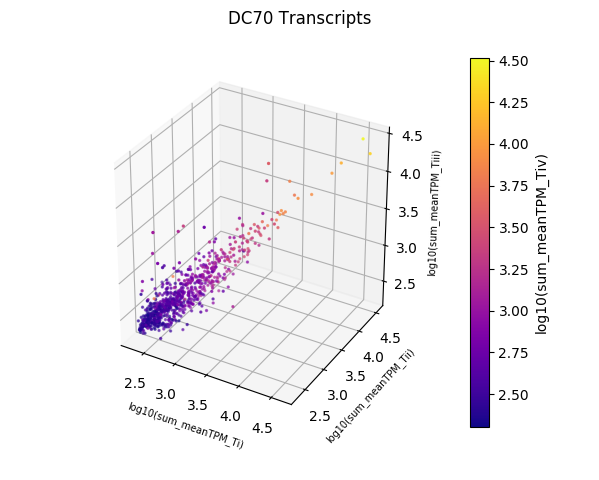

In [31]:
for species in all_species:
    
    # Create a new figure.
    fig = plt.figure(figsize=plt.figaspect(0.8))

    # Extract the subplot at index (i+1) from the figure. 
    # Why are the indicies expected to not be zero indexed in the 'add_subplot' function? 
    # Thats really weird. But, whatever.
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    
    df = data.loc[data['species']==species][['sum_meanTPM_Ti','sum_meanTPM_Tii','sum_meanTPM_Tiii','sum_meanTPM_Tiv']]
    
    df = df.rename(columns={
        'sum_meanTPM_Ti':'x', 
        'sum_meanTPM_Tii':'y', 
        'sum_meanTPM_Tiii':'z', 
        'sum_meanTPM_Tiv':'c'
    })
    
    df = df[df['x'] > 200]
    df = df[df['y'] > 200]
    df = df[df['z'] > 200]
    df = df[df['c'] > 200]

    # Supress massive values by taking log. 
    # Values may be massive becuase of large expression levels or misreads. 
    df['x'] = np.log10(df['x'])
    df['y'] = np.log10(df['y'])
    df['z'] = np.log10(df['z'])
    df['c'] = np.log10(df['c'])
    
    # Add data to plot.
    p = ax.scatter(df['x'], df['y'], df['z'], c=df['c'], cmap=plt.cm.plasma, s = 2);
    
    # Axis Labels
    ax.set_xlabel('log10(sum_meanTPM_Ti)', fontsize=7)
    ax.set_ylabel('log10(sum_meanTPM_Tii)', fontsize=7)
    ax.set_zlabel('log10(sum_meanTPM_Tiii)', fontsize=7)
    
    fig.suptitle(species + " Transcripts")
    cbar = fig.colorbar(p, pad = 0.1)
    cbar.set_label('log10(sum_meanTPM_Tiv)')
    

## Normalization

This analysis just cares about how the genes expression changes over time. We don't care about how many genes are expressed at each time point. So, we normalize.

In [32]:
# Normalizes a row.
def normalize_row(row):
    return (row - row.min()) / (row.max() - row.min())    

# These are the columns we are normalizing.
column_names = ['sum_meanTPM_Ti', 'sum_meanTPM_Tii', 'sum_meanTPM_Tiii', 'sum_meanTPM_Tiv']
    
# Normalize the sum_meanTPM columns for each row.
data[column_names] = data[column_names].apply(normalize_row, axis=1)

## Clustering

Discounting color we can see 3 distinct bands. Each one of these represents a group of genes with similar expression curves. 

These bands do not follow the good clustering principal. So it is very difficult to tease them appart. Especially when we consider the 4th dimension (color). 

So we use singular vector decomposition to reduce the dimensionality and create groups that follow the good clustering principal. 

<IPython.core.display.Javascript object>


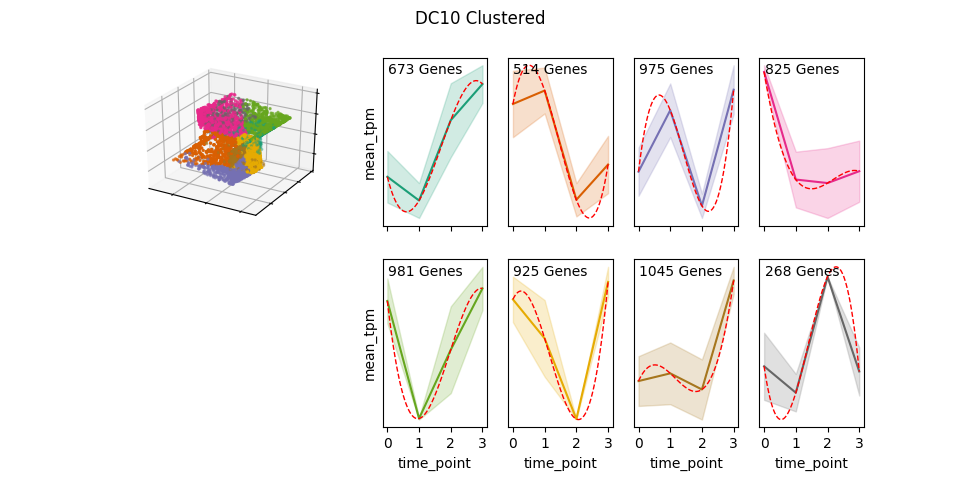

<IPython.core.display.Javascript object>


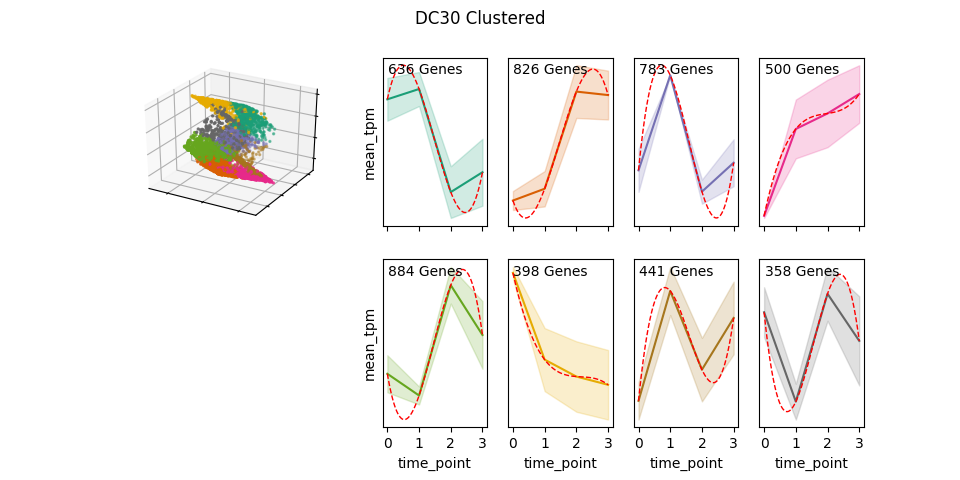

<IPython.core.display.Javascript object>


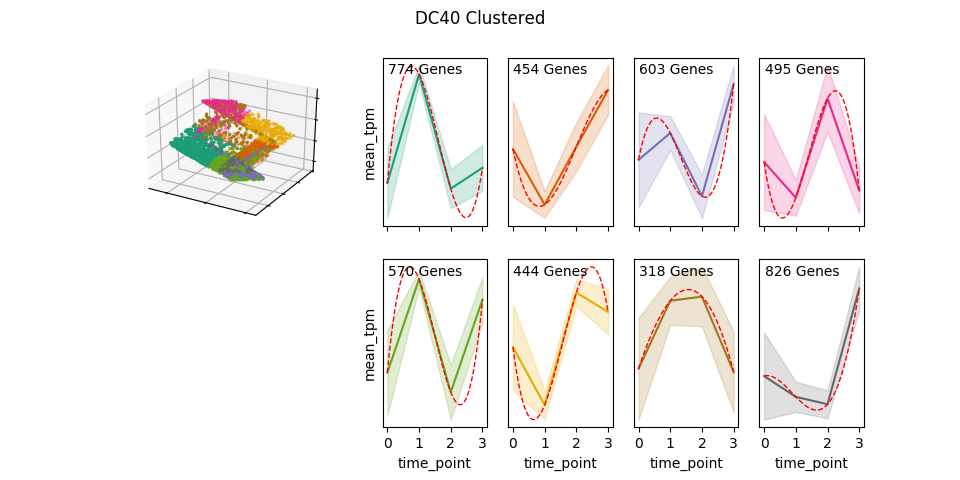

<IPython.core.display.Javascript object>


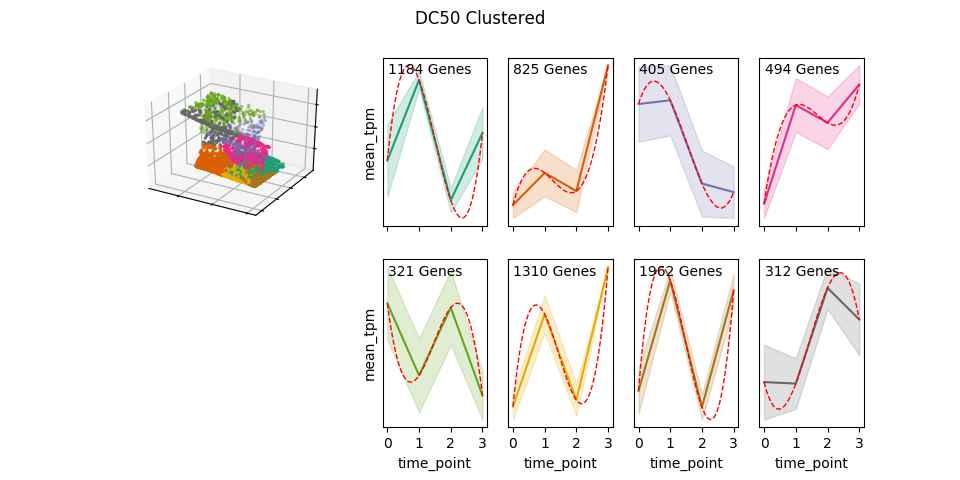

<IPython.core.display.Javascript object>


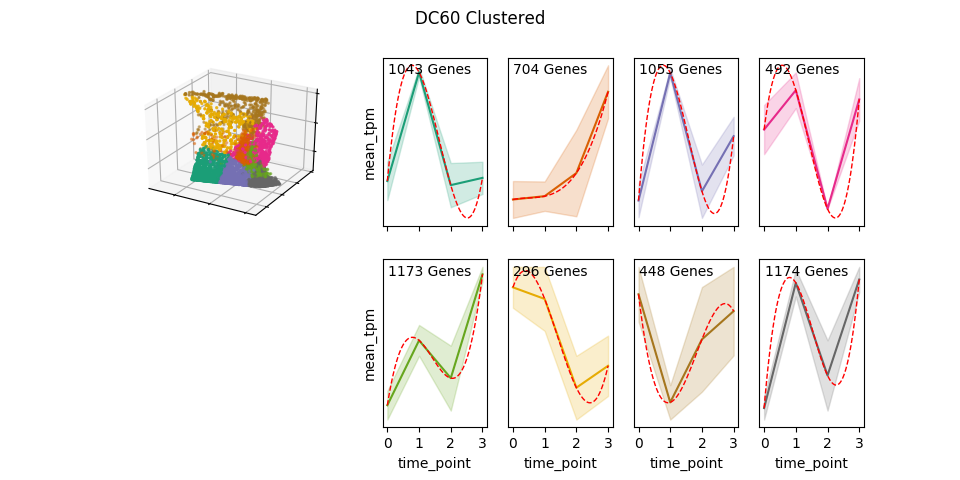

<IPython.core.display.Javascript object>


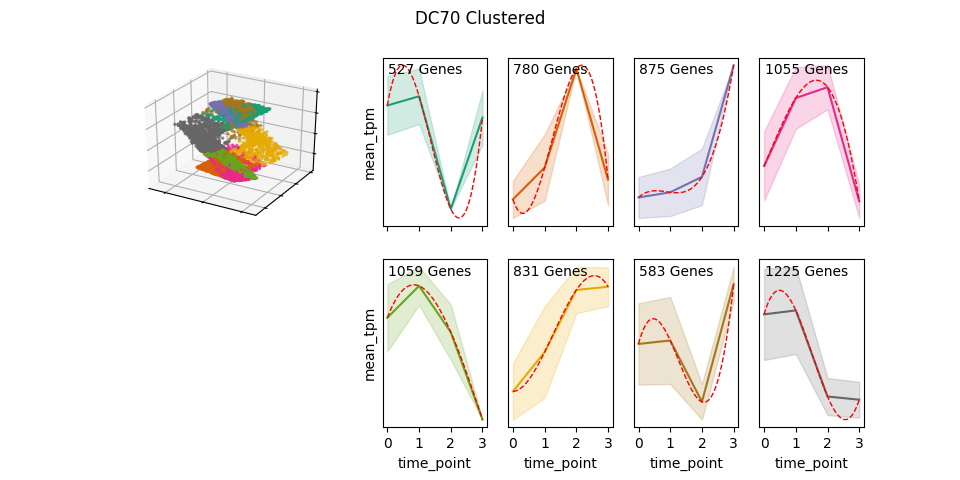

In [45]:
data['cluster'] = np.nan
data['fit_const_A'] = np.nan
data['fit_const_B'] = np.nan
data['fit_const_C'] = np.nan
data['fit_const_D'] = np.nan

def format_axes(ax, label):
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.text(0.5, 0.5, s=label, va="center", ha="center")
    
def cubic_curve(x, a, b, c, d):
    return a*(x**3)+b*(x**2)+c*(x)+d

for species in all_species:
    
    # Create a figure.
    fig = plt.figure(figsize=plt.figaspect(0.5))

    # The figure contains 3 subsections.
    gs0 = gridspec.GridSpec(1, 3, figure=fig)

    ######################
    ##### CLUSTERING #####
    ######################
    
    # The first subsection is for the clustering - so the left 1/3 of the result is a 3d scatter plot.
    gs00 = gs0[0].subgridspec(2, 1)
    clustering_ax = fig.add_subplot(gs00[0,0], projection='3d')
    
    # Create a object that can perform the singular vector decomposition
    svd = TruncatedSVD(n_components=3)
    
    # We perform the singular vector decomposition.
    # This results in a 3 dimensional data set.
    column_names = ['sum_meanTPM_Ti', 'sum_meanTPM_Tii', 'sum_meanTPM_Tiii', 'sum_meanTPM_Tiv']
    reduced = svd.fit_transform(data.loc[data['species']==species][column_names])
    
    # Converting the result to a dataframe.
    reduced_df = pd.DataFrame(data=reduced, columns = ["x", "y", "z"])
    
    # My man Kartik Krishnan says that 8 clusters are where its at.
    pred = KMeans(n_clusters = num_clusters).fit_predict(reduced_df)
    
    # Lets plot it. We color based off the color. 
    x = reduced_df["x"]
    y = reduced_df["y"]
    z = reduced_df["z"]
    r = pred
    clustering_ax.scatter(x, y, z, c=r, cmap=Dark2, s=2);
    clustering_ax.tick_params(labelbottom=False, labelleft=False)
    
    data.loc[data['species']==species,'cluster'] = pred

    
    ######################################
    ##### EXTRACTING CLUSTERED CURVES ####
    ######################################
    
    # The curves subsection takes the secion two subsections - so the rigth 2/3 of the result are curves.
    gs01 = gs0[1:3].subgridspec(2, 4)

    df = data.loc[data['species']==species]
    
    df = pd.melt(df, 
                 id_vars = ['PanID', 'cluster'], 
                 value_vars=['sum_meanTPM_Ti', 'sum_meanTPM_Tii','sum_meanTPM_Tiii','sum_meanTPM_Tiv'],
                 var_name='time_point',
                 value_name='mean_tpm')
    
    df = df.replace('sum_meanTPM_Ti', 0)
    df = df.replace('sum_meanTPM_Tii', 1)
    df = df.replace('sum_meanTPM_Tiii', 2)
    df = df.replace('sum_meanTPM_Tiv', 3)
    

    for i in range(num_clusters):
        
        ##############################
        ##### CUBIC CURVE FITTING ####
        ##############################
        
        cluster_df = df[df['cluster'] == i]
            
        popt, pcov = curve_fit(cubic_curve, cluster_df['time_point'], cluster_df['mean_tpm'])
        
        cubic_fit_xs = np.linspace(0,3,100)
        cubic_fit_ys = cubic_curve(cubic_fit_xs, popt[0], popt[1], popt[2], popt[3])
    
        # For some reason 
        # 
        # df.loc[(df['species']==species) & (df['cluster'] == i), 'fit_const_A'] = popt[0]
        # 
        # Did not work EVEN THOUGH THE DOCUMENTATION SAYS IT SHOULD 
        data['fit_const_A'] = pd.np.where( (data['species'] == species ) & (data['cluster'] == i), popt[0], data['fit_const_A'])
        data['fit_const_B'] = pd.np.where( (data['species'] == species ) & (data['cluster'] == i), popt[1], data['fit_const_B'])
        data['fit_const_C'] = pd.np.where( (data['species'] == species ) & (data['cluster'] == i), popt[2], data['fit_const_C'])
        data['fit_const_D'] = pd.np.where( (data['species'] == species ) & (data['cluster'] == i), popt[3], data['fit_const_D'])

        num_genes = int(cluster_df.shape[0]/4)
        
        ax = fig.add_subplot(gs01[i//4, i%4])
        ax = sns.lineplot(x="time_point",
                          y="mean_tpm", 
                          data=cluster_df, 
                          ci='sd',
                          color=Dark2(i/8))
        
        ax.plot(cubic_fit_xs, cubic_fit_ys, linestyle='dashed', color='r', linewidth=1)
        
        ax.annotate(str(num_genes) + " Genes",xy=(0.05,0.9),xycoords='axes fraction')
        ax.label_outer()
        ax.set_xticks([0,1,2,3]) 
        ax.set_yticks([]) 
        
        
    plt.suptitle(species + " Clustered")

    plt.show()

## Curve Clustering

<IPython.core.display.Javascript object>


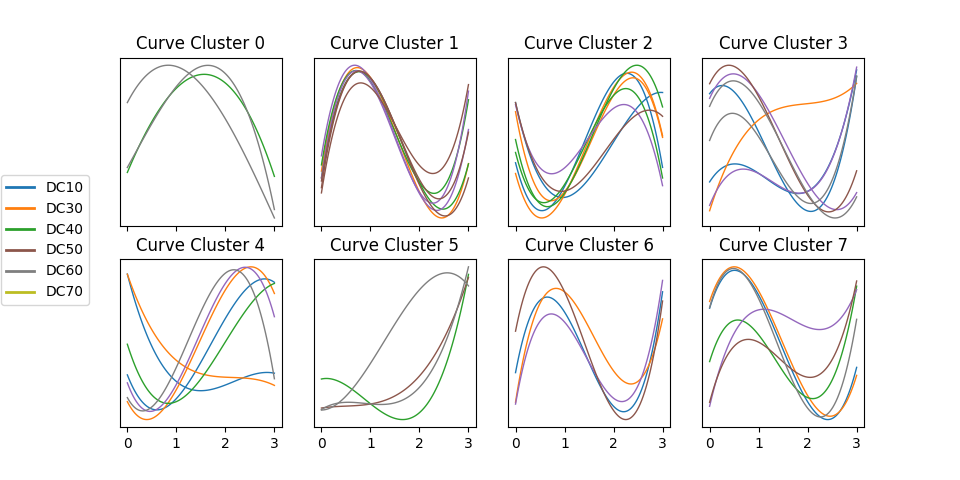

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


In [46]:
# The fact that I can do this complete clustering with one line in python ridiculous. 
data['curve_cluster'] = KMeans(n_clusters = 8).fit_predict(data[["fit_const_A","fit_const_B","fit_const_C"]])

fig = plt.figure(figsize=plt.figaspect(0.5))

curve_cluster_df = data[['species','fit_const_A','fit_const_B','fit_const_C','fit_const_D','curve_cluster']]

curve_cluster_df = curve_cluster_df.drop_duplicates()

for i, species in enumerate(all_species):
    curve_cluster_df = curve_cluster_df.replace(species, i)

for i, row in curve_cluster_df.iterrows():  
    ax = fig.add_subplot(2, 4, row['curve_cluster'] + 1)
    xs = np.linspace(0,3,100)
    ys = cubic_curve(xs, row['fit_const_A'], row['fit_const_B'], row['fit_const_C'], row['fit_const_D'])
    ax.plot(xs, ys, linewidth=1, color = tab10(row['species']/8))
    ax.label_outer()
    ax.set_xticks([0,1,2,3]) 
    ax.set_yticks([]) 
    ax.set_title('Curve Cluster ' + str(int(row['curve_cluster'])))
    

lines = []
for i, species in enumerate(all_species):
    lines.append(Line2D([0], [0], color=tab10(i/6), lw=2))
    
fig.legend(lines, all_species, loc='center right',bbox_to_anchor=(0.1, 0.5))

In [47]:
target_gene_df = pd.DataFrame(columns=["PanID", "species", "curve_cluster", "Pannot"])

pan_ids = data['PanID'].unique()

for pan_id in pan_ids:
    
    pan_id_df = data.loc[data['PanID']==pan_id]
    
    if(pan_id_df['species'].nunique() > 1 and pan_id_df['curve_cluster'].nunique() == 1):
        species = pan_id_df['species'].unique()
        curve_cluster = pan_id_df['curve_cluster'].unique()[0]
        pannot = pan_id_df['Pannot'].unique()[0]
        target_gene_df = target_gene_df.append({'PanID': pan_id, 'species': species, 'curve_cluster':curve_cluster, 'Pannot':pannot}, ignore_index=True)
        
target_gene_df

PanID       species curve_cluster  \
0      PTHR10067:SF2  [DC10, DC60]             2   
1      PTHR10091:SF8  [DC10, DC50]             2   
2     PTHR10333:SF75  [DC10, DC60]             6   
3          PTHR10416  [DC10, DC60]             2   
4      PTHR10468:SF0  [DC10, DC70]             3   
..               ...           ...           ...   
472   PTHR12320:SF16  [DC60, DC70]             3   
473   PTHR23070:SF17  [DC60, DC70]             3   
474  PTHR24092:SF141  [DC60, DC70]             7   
475    PTHR36359:SF1  [DC60, DC70]             5   
476    PTHR47317:SF1  [DC60, DC70]             5   

                                                Pannot  
0         PHOSPHATIDYLSERINE DECARBOXYLASE PROENZYME 2  
1                                                  NaN  
2                                                  NaN  
3                       DNA POLYMERASE DELTA SUBUNIT 2  
4    ALPHA-1,3-MANNOSYL-GLYCOPROTEIN 2-BETA-N-ACETY...  
..                                                 ...  
472                                                NaN  
473                       MITOCHONDRIAL CHAPERONE BCS1  
474                                                NaN  
475                       RESISTANCE TO PHYTOPHTHORA 1  
476                  PROTEIN LHCP TRANSLOCATION DEFECT  

[477 rows x 4 columns]

In [48]:
target_gene_df.to_csv("output/target_genes.csv", sep=',')